 # Swish Analytics
 
Goal: using the provided MLB data, review the dataset and outline the way I would go about the model-building process with the goal of predicting the probability that the next thrown pitch is a certain type. 

#### Read in Data

In [52]:
# import 
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
%matplotlib inline

shap.initjs()
seed = 42

In [ ]:
# read in the data
data = pd.read_csv("pitches_folder/pitches", sep=",", low_memory=False)

#### Data Exploration & Preprocessing

Let's take a look at the data and see what we're working with.

In [ ]:
data.shape  

(718961, 125)

In [ ]:
data.head()

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,is_final_pitch,final_balls,final_strikes,final_outs,start_tfs,start_tfs_zulu,batter_id,stand,b_height,pitcher_id,p_throws,at_bat_des,event,event2,event3,event4,away_team_runs,home_team_runs,score,pitch_des,pitch_id,type,pitch_tfs,pitch_tfs_zulu,x,y,sv_id,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,z0,y0,vx0,vz0,vy0,ax,az,ay,break_length,break_y,break_angle,pitch_type,type_confidence,zone,nasty,spin_dir,spin_rate,cc,on_1b,on_2b,on_3b,runner1_id,runner1_start,runner1_end,runner1_event,runner1_score,runner1_rbi,runner1_earned,runner2_id,runner2_start,runner2_end,runner2_event,runner2_score,runner2_rbi,runner2_earned,runner3_id,runner3_start,runner3_end,runner3_event,runner3_score,runner3_rbi,runner3_earned,runner4_id,runner4_start,runner4_end,runner4_event,runner4_score,runner4_rbi,runner4_earned,runner5_id,runner5_start,runner5_end,runner5_event,runner5_score,runner5_rbi,runner5_earned,runner6_id,runner6_start,runner6_end,runner6_event,runner6_score,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,1,0,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,Ball,3,B,201301.0,2011-03-31 20:13:01,105.58,180.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,2,1,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,Ball,4,B,201319.0,2011-03-31 20:13:19,99.57,170.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,3,2,0,0,0,0,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,Called Strike,5,S,201327.0,2011-03-31 20:13:27,95.28,152.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,4,2,1,0,0,1,2,1,1,201226,2011-03-31 20:12:26,430895,L,5-8,460024,R,"Maicer Izturis grounds out, second baseman Chr...",Groundout,NaN,NaN,NaN,0,0,NaN,"In play, out(s)",6,X,180441.0,2011-03-31 18:04:41,93.56,168.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,5,0,0,0,1,0,2,2,1,201354,2011-03-31 20:13:54,435062,R,5-10,460024,R,Howie Kendrick doubles (1) on a line drive to ...,Double,NaN,NaN,NaN,0,0,N

It looks like a significant portion of columns are completely null and won't be usable for this analysis. 

I'll stick with data where `pitch_type` is not null, since that is the value to be predicted, and remove columns that are entirely or mostly empty.

In [ ]:
# check for null values
total = data.isnull().sum().sort_values(ascending=False)
pct = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, pct], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
runner4_event,718961,1.0
runner4_score,718961,1.0
runner4_rbi,718961,1.0
runner4_earned,718961,1.0
runner5_id,718961,1.0
...,...,...
stand,0,0.0
created_at,0,0.0
added_at,0,0.0
modified_at,0,0.0


I need to trim down the data into what is actually useful. So removing columns that are entirely empty, rows where the target feature is empty, columns that aren't relevant to predicting the pitch type, etc. 

I also need to do some feature engineering and convert categorical data into numerical data for EDA and modeling purposes.

The features will be further trimmed down during the modeling stage, where I can discover which features are most impactful for predictive purposes.

In [ ]:
# check the data types of the columns
data.dtypes

uid                 int64
game_pk             int64
year                int64
date               object
team_id_b           int64
                   ...   
runner7_earned    float64
created_at         object
added_at           object
modified_at        object
modified_by         int64
Length: 125, dtype: object

In [ ]:
# get columns where the data is entirely or mostly missing and drop them
data = data.drop((missing_data[missing_data['Percent'] > 0.5]).index,axis=1)

# confirm they're gone
data.isnull().sum().max()

# drop rows where `pitch_type` is null
data = data[~data['pitch_type'].isnull()]

# drop columns that aren't relevant to predicting pitch type or that are redundant or I don't have time to explore further at the moment
cols = [
        'uid' 
        , 'game_pk' 
        , 'year'
        , 'date'
        , 'team_id_b'
        , 'team_id_p'
        , 'start_tfs'
        , 'start_tfs_zulu'
        , 'batter_id' 
        , 'pitcher_id' 
        , 'at_bat_des' 
        , 'event'
        , 'away_team_runs'
        , 'home_team_runs'
        , 'pitch_des'
        , 'pitch_id'
        , 'pitch_tfs'
        , 'pitch_tfs_zulu' 
        , 'created_at' 
        , 'added_at'
        , 'modified_at' 
        , 'modified_by' 
        , 'sv_id'
        ]

# feature engineering & refactoring

# let's get the total runs at the time of the pitch, by either team
data['total_runs'] = data['away_team_runs'] + data['home_team_runs']

# convert binary columns into numerical 
data['stand'] = pd.factorize(data['stand'])[0]
data['p_throws'] = pd.factorize(data['p_throws'])[0]
data['type'] = pd.factorize(data['type'])[0]

# convert pitch type into numerical
le = LabelEncoder() 
data['pitch_type_en'] = le.fit_transform(data['pitch_type'])

# convert batter's height into inches
data['b_height'] =  (data.b_height.str.split("-").str[0].astype(int) * 12) + (data.b_height.str.split("-").str[1].astype(int))

data = data.drop(data[cols], axis=1)

I want a quick glimpse into what the pitch types and feature correlations look like. 

For the types of pitches, the data is heavily skewed towards `FF`, then `SL`, `SI`, `FT`, `CH`, `CU`, `FC` to a lesser extent. 

<Axes: xlabel='pitch_type', ylabel='count'>

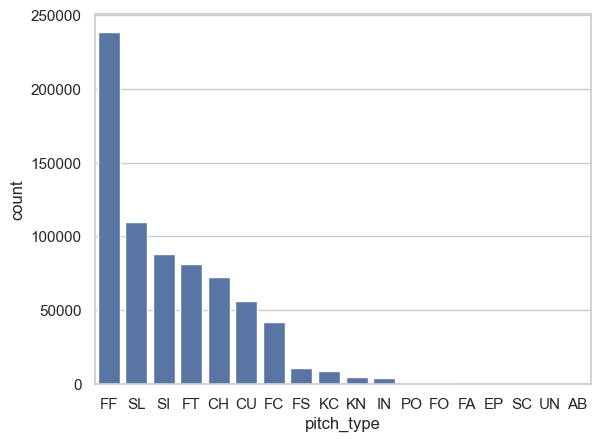

In [ ]:
# let's look at the distinct types of pitches and how common they are in the data set 
sns.countplot(x='pitch_type'
              , data=data
              , order=data['pitch_type'].value_counts().index)

In [ ]:
# compute pearson correlation between target and all features
corr_data = data.loc[:, data.columns != 'pitch_type']
target = 'pitch_type_en'
corr = {}
for col in corr_data:
    if target != col:
        corr[col + '_' + target] = \
            pearsonr(corr_data[col], corr_data[target])[0]

# get most negatively correlated and positively correlated
corr = dict(sorted(corr.items(), key=lambda item: item[1]), reverse=False)
corr

C:\Users\orgil\AppData\Local\Temp\ipykernel_11260\568061709.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(corr_data[col], corr_data[target])[0]


{'spin_rate_pitch_type_en': np.float64(-0.21586141041676654),
 'type_confidence_pitch_type_en': np.float64(-0.12455715859212306),
 'z0_pitch_type_en': np.float64(-0.1195542009308572),
 'az_pitch_type_en': np.float64(-0.11078179732152055),
 'vy0_pitch_type_en': np.float64(-0.09205164649494818),
 'pfx_z_pitch_type_en': np.float64(-0.08386905089763297),
 'pcount_pitcher_pitch_type_en': np.float64(-0.06489281788275605),
 'p_throws_pitch_type_en': np.float64(-0.06399795533119498),
 'x0_pitch_type_en': np.float64(-0.05489561488267129),
 'stand_pitch_type_en': np.float64(-0.04836421935731722),
 'x_pitch_type_en': np.float64(-0.04670308083795766),
 'pz_pitch_type_en': np.float64(-0.029616121408607966),
 'ax_pitch_type_en': np.float64(-0.02885169190405808),
 'pfx_x_pitch_type_en': np.float64(-0.027585661730305872),
 'spin_dir_pitch_type_en': np.float64(-0.022343493645269788),
 'final_balls_pitch_type_en': np.float64(-0.010439847546553027),
 'final_strikes_pitch_type_en': np.float64(-0.008096492

The correlations between the features and `pitch_type` range between -0.22 and 0.11, so not insanely strong correlations but there is something there. I'll keep the features with the stronger correlations in mind as I get into the variable selection phase. 

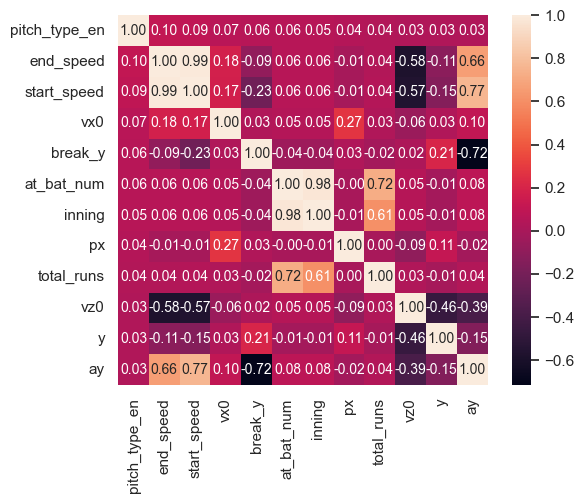

In [ ]:
# calculate correlations
corr_data = data.loc[:, data.columns != 'pitch_type']
corr_matrix = corr_data.corr()

# get heat map with regards to pitch_type and the most correlated features
k = 12
cols = corr_matrix.nlargest(k, 'pitch_type_en')['pitch_type_en'].index
cm = np.corrcoef(corr_data[cols].values.T)
sns.set_theme(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Train Test Split

I want to build a baseline model with the data I have then iteratively improve on the model by removing features that aren't impactful.  In general, it's better to have a simpler model that doesn't introduce more randomness to the model by accident than what is there naturally.

First step is to split the data into training and testing sets.

In [ ]:
# get the cleaned up data
df = data.loc[:, data.columns != 'pitch_type']

In [ ]:
df.shape

(716681, 46)

In [ ]:
# train test split
def pd_train_test_split(df: pd.DataFrame, 
                        ratio: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Given an input df containing all data and the target variable, split the data into training and testing sets
    
    Params
    ------
    df : pd.DataFrame
        df of all data, features and actuals across all dates.
        
    Returns
    -------
    Tuple[pd.DataFrame, pd.Dataframe]
        The training set and the test set, respectively
    """
    total_rows = df.shape[0]
    train_size = int(total_rows*ratio)

    # shuffle the data
    df=df.sample(frac=1)

    # split data into test and train sets
    df_train = df[0:train_size]
    df_test = df[train_size:]
    
    return df_train, df_test

In [ ]:
# get the 80/20 training and testing data
df_train, df_test = pd_train_test_split(df=df, ratio=0.8)

In [ ]:
df_train.sample(2)

,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,is_final_pitch,final_balls,final_strikes,final_outs,stand,b_height,p_throws,type,x,y,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,z0,y0,vx0,vz0,vy0,ax,az,ay,break_length,break_y,break_angle,type_confidence,zone,nasty,spin_dir,spin_rate,total_runs,pitch_type_en
278558,7,0,52,6,8,3,2,0,1,1,3,3,2,0,73,0,0,93.56,120.02,90.9,82.8,3.47,1.67,-1.85,9.86,0.230,3.495,0.016,6.098,50.0,1.187,-4.029,-133.205,-3.290,-14.576,31.614,3.6,23.7,11.0,2.00,12.0,46.0,190.588,1949.867,3,6
46713,2,0,14,1,23,0,0,0,1,0,1,1,3,0,72,1,1,51.50,154.56,89.3,81.7,3.41,1.59,10.37,3.68,1.504,2.273,1.960,5.739,50.0,-4.627,-3.897,-130.836,17.768,-25.784,30.488,7.5,23.7,-32.1,0.93,14.0,32.0,109.781,2093.753,0,9


#### Baseline Model

Since I want to predict the probability of the type of pitch that will occur, a random forest model is a good choice.

In [ ]:
def train_randomforest_model(df_train: pd.DataFrame, 
                             y_name: str, 
                             X_names: List[str]) -> RandomForestClassifier:
    """
    Train a RandomForest model to predict df[y_name] using df[X_Names]
    
    Params
    ------
    df_train : pd.DataFrame
        Training dataset of features and actuals
    y_name : str
        Name of column containing the outcome variable
    X_names : List[str]
        List of name(s) of column(s) containing the features
        
    Returns
    -------
    trained random forest model
    """
    # Extract outcome variable and features from df_train
    y_train = df_train[y_name]
    X_train = df_train[X_names]
    
    # Instantiate model 
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Train model
    model.fit(X_train, y_train)
    
    return model

In [ ]:
# get all feature column names and the target variable
X_names = [i for i in df_train.columns if i not in ["pitch_type", "pitch_type_en"]]
y_name = 'pitch_type_en'

In [ ]:
# train a baseline model
model = train_randomforest_model(df_train = df_train, y_name = y_name, X_names = X_names)

#### Evaluation

Next up is to evaluate how the model performed and I will use R2 and MAE for this.

In [ ]:
def evaluate_accuracy(model: RandomForestClassifier,
                      df_test: pd.DataFrame,
                      y_name: str,
                      X_names: List[str]) -> Tuple[float, float, np.array]:
    """
    Given a trained model and a test set, evaluate model accuracy.
    First we generate predictions using df_test[X_names]. Then we compare
    the predictions to df_test[y_name] to calculate R^2 and MAE.
    
    Params
    ------
    model : RandomForestClassifier
        Trained RandomForest model
    df_test : pd.DataFrame
        Test dataset containing features and actuals
    y_name : str
        Name of column containing the outcome variable
    X_names : List[str]
        List of name(s) of column(s) containing the features
        
    Returns
    -------
    Tuple[float, float]
        The R^2 and MAE metrics, respectively
    np.array
        The raw predictions
    """
    # Generate predictions
    predictions = model.predict(df_test[X_names])
    probabilities = np.max(model.predict_proba(df_test[X_names]), axis = 1)
    
    # Compute metrics
    r2 = r2_score(df_test[y_name], predictions)
    mae = mean_absolute_error(df_test[y_name], predictions)
    
    return r2, mae, predictions, probabilities

In [ ]:
r2, mae, predictions, probabilities = evaluate_accuracy(model = model, df_test = df_test, y_name = y_name, X_names = X_names)

In [ ]:
print(f'R^2: {r2}, MAE: {mae}')

R^2: 0.5888443291781691, MAE: 1.1079065419256717


The moderate R2 suggests this model explains a good amount of the variation in the target variable and the low MAE suggests that the model predictions aren't usually far off the actual pitch type on average.

Remember, this is just the baseline model with no additional adjustments made to it so there is a lot of room for improvement!

For ease of viewing, let's throw the predictions and their probabilities back into the test data to see how it all compares. 

In [ ]:
# add the predictions and probabilities back into the test data
df_test['prediction'] = predictions
df_test['probability'] = probabilities

# undo the label encoding from earlier to better see the predictions and actuals
df_test['pitch_type_actual'] =  le.inverse_transform(df_test['pitch_type_en'])
df_test['prediction_unen'] = le.inverse_transform(df_test['prediction'])

In [ ]:
output = df_test[['pitch_type_actual', 'pitch_type_en', 'prediction', 'prediction_unen', 'probability']]

In [ ]:
output.head(15)

,pitch_type_actual,pitch_type_en,prediction,prediction_unen,probability
392461,FS,8,9,FT,0.43
494785,FT,9,9,FT,0.72
706769,CU,2,2,CU,0.98
307305,FF,6,6,FF,0.99
548993,CU,2,2,CU,0.82
503717,FF,6,9,FT,0.46
453343,CH,1,1,CH,0.98
201123,FT,9,9,FT,0.76
145167,SL,16,16,SL,0.94
632378,CU,2,2,CU,0.77


## Conclusion & Next Steps

With more time to work on this project, I would want to be more thorough with EDA. I could probably save myself some pain down the line so I could potentially highlight important features before getting to the modeling stage.

I would want to test some engineered features to see how they impact the model, such as the result of the previous pitch thrown by this pitcher (strikeout, hit, etc) and the type pitch most recently thrown by the pitcher (perhaps some pitchers stick to one or two types and others try try to mix it up every time they throw).  I would also like to explore how the pitcher height vs the batter height and if the pitcher's team is currently winning may possibly impact the type of pitch thrown. Some of these may not be relevant to the model, but it wouldn't hurt to explore.

Most importantly, I would want to do many more iterations of the modeling to ensure overfitting isn't a huge issue and improve evaluation metrics. In general, I would want to spend more time on the variable selection stage to really nail down the best features to use in the model and to keep it simple - no redundant features. I would test several different methods to do this - perhaps Stepwise Regression or LASSO to eliminate unneeded features or Elastic Net to weight features according to how useful they are.

I normally would do a baseline model and then continue refining the model by digging into feature importance and iteratively testing the model with different features until I find the set that works best for predictive purposes without overfitting, using a library like SHAP. This would give me an idea of both the feature importance and the directionality of the features. I would also want to include more metrics for evaluation - a confusion matrix and AUC, probably. But this is a good start for a baseline model.